In [6]:
#plt.plot(x)
#plt.show()

In [5]:
import numpy as np
import pandas as pd
import timeit
import numba
import math

import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns # data visualization Library 

from scipy import stats
from scipy.stats import moment, skew, kurtosis

%matplotlib inline


np.random.seed(1)

In [7]:
# Closed-Form Lookback Function
def lookback_Analytic(S,K,r,q,sigma,T,flavor = 'fixed strike call',t=0):
    dt = T-t
    d1 = ((np.log(S/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) + 0.5*sigma*np.sqrt(dt)
    d2 = ((np.log(S/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) - 0.5*sigma*np.sqrt(dt)
    d1_ = ((np.log(S/K) - (r - q)*(dt)) / sigma*np.sqrt(dt)) - 0.5*sigma*np.sqrt(dt)
    d2_ = ((np.log(S/K) - (r - q)*(dt)) / sigma*np.sqrt(dt)) + 0.5*sigma*np.sqrt(dt)
    
    euro_call = S*np.exp(-q*dt)*norm.cdf(d1) - K*np.exp(-r*dt)*norm.cdf(d2)
    euro_put = K*np.exp(-r*dt)*norm.cdf(d2_) - S*np.exp(-q*dt)*norm.cdf(d1_)
    
    lookback1 = np.exp(-r*dt)*(sigma*sigma/(2*r))*S
    lookback_c = (np.exp(r*dt)*norm.cdf(d1) - (np.power((S/K),(-(2*r)/(sigma*sigma))))*norm.cdf(d1-(((2*r)/(sigma))*np.sqrt(dt))))
    lookback_p = (np.power((S/K),(-(2*r)/(sigma*sigma))))*norm.cdf(-d1+(((2*r)/(sigma))*np.sqrt(dt)))-(np.exp(r*dt)*norm.cdf(-d1))
    
    if flavor == 'fixed strike call':
        price =  euro_call + lookback1*lookback_c
    if flavor == 'fixed strike put':
        price = euro_put + lookback1*(lookback_p)
    
    
    return price


In [8]:
# Black-Scholes European Pricer
def BS(S,K,r,q,sigma,T,flavor='c',style='euro',display='no',t=0):
    dt = T-t
    d1 = ((np.log(S/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) + 0.5*sigma*np.sqrt(dt)
    d2 = ((np.log(S/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) - 0.5*sigma*np.sqrt(dt)
    d1_ = ((np.log(S/K) - (r - q)*(dt)) / sigma*np.sqrt(dt)) - 0.5*sigma*np.sqrt(dt)
    d2_ = ((np.log(S/K) - (r - q)*(dt)) / sigma*np.sqrt(dt)) + 0.5*sigma*np.sqrt(dt)
    if flavor == 'c':
        price = S*np.exp(-q*dt)*norm.cdf(d1) - K*np.exp(-r*dt)*norm.cdf(d2)
        delta = np.exp(-q*dt)*norm.cdf(d1)
        gamma = np.exp(-q*dt)*(1/(S*sigma*np.sqrt(dt)))*norm.pdf(d1)
        vega = S*np.exp(-q*dt)*np.sqrt(dt)*norm.pdf(d1)
        theta = -S*sigma*np.exp(-q*dt)*(1/(2*np.sqrt(dt)))*norm.pdf(d1) +q*S*np.exp(-q*dt)*norm.cdf(d1) - r*K*np.exp(-r*dt)*norm.cdf(d2)
        rho_q = -dt*S*np.exp(-q*T)*norm.cdf(d1)
    if flavor == 'p':
        price = K*np.exp(-r*dt)*norm.cdf(d2_) - S*np.exp(-q*dt)*norm.cdf(d1_)
        delta = -np.exp(-q*dt)*norm.cdf(d1_)
        gamma = np.exp(-q*dt)*(1/(S*sigma*np.sqrt(dt)))*norm.pdf(d1)
        vega = S*np.exp(-q*dt)*np.sqrt(dt)*norm.pdf(d1)
        theta = -S*sigma*np.exp(-q*dt)*(1/(2*np.sqrt(dt)))*norm.pdf(d1) -q*S*np.exp(-q*dt)*norm.cdf(d1_) + r*K*np.exp(-r*dt)*norm.cdf(d2_)
    if display == "yes":
        print("Price: {:.4f}".format(price))
        print("Delta: {:.4f}".format(delta))
        print("Gamma: {:.4f}".format(gamma))
        print("Vega: {:.4f}".format(vega))
        print("Theta: {:.4f}".format(theta))
    return price, delta, gamma, vega, theta, rho_q

In [9]:
# run formulas over specified range
krange = np.linspace(1.0,1.3,100)
krange_inf = np.linspace(0.01,3,100)
n = 100000
S = 2885
K = S*krange
Kinf = S*krange_inf
r = .023
q = .0198
sigma = 0.157
T = 1
dt = T/252
results = []
resultsI = []
resultsBS = []
resultsBSI = []

for k in K:
    results.append(lookback_Analytic(S,k,r,q,sigma,T,'fixed strike call'))
    resultsBS.append(BS(S,k,r,q,sigma,T,flavor='c',style='euro',display='no',t=0)[0])
for k in Kinf:
    resultsI.append(lookback_Analytic(S,k,r,q,sigma,T,'fixed strike call'))
    resultsBSI.append(BS(S,k,r,q,sigma,T,flavor='c',style='euro',display='no',t=0)[0])


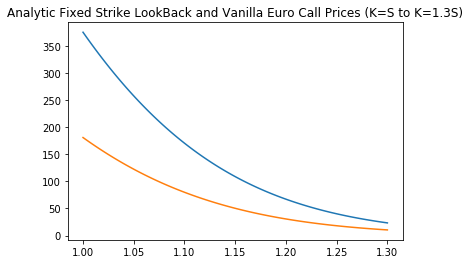

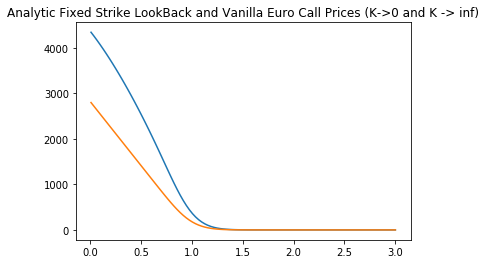

In [10]:
# plot analytic solution vs K for 1.0 <= (K/So) <= 1.3
plt.title("Analytic Fixed Strike LookBack and Vanilla Euro Call Prices (K=S to K=1.3S)")
plt.plot(krange,results,krange,resultsBS)
plt.show()

plt.title("Analytic Fixed Strike LookBack and Vanilla Euro Call Prices (K->0 and K -> inf)")
plt.plot(krange_inf,resultsI,krange_inf,resultsBSI)
plt.show()

In [11]:
# price ATM lookback fixed strike and vanilla euro calls

S = 2885
K = 2885
r = .023
q = .0198
sigma = 0.157
T = 1

LBatm = lookback_Analytic(S,K,r,q,sigma,T,'fixed strike call')
ECatm = BS(S,K,r,q,sigma,T,flavor='c',style='euro',display='no',t=0)[0]

print('Value of ATM fixed strike lookback call: {:.2f}'.format(LBatm))
print('Value of ATM vanilla euro call: {:.2f}'.format(ECatm))
print('Ratio of lookback to vanilla: {:.2f}'.format(LBatm/ECatm))

Value of ATM fixed strike lookback call: 375.97
Value of ATM vanilla euro call: 181.25
Ratio of lookback to vanilla: 2.07


In [12]:
# Lookback Option Monte Carlo Function
def lookback_MC(batches, freqs, S,K,r,q,sigma,T,flavor='c',style='float',display='no',t=0,antithetic='no'):
    '''This function generate batches of n normally distributed random variables, which are used to generate 
    a geometric brownian motion along m sample paths.  Then we calculate the maximum values, for each batch, along
    each m paths for the specified frequency of m.  We end up with a row vector of n maximums, which are then
    used to calculate the payoff.  We take the mean of each of these, and discount to the present value.'''
    num_steps = 252
    dt = T/num_steps
    
    ST = np.zeros((num_steps+1,batches))
    
    
    Smax = []
    Smin = []
    ST[0,:] = S
    
    
    
    payout = np.zeros(num_steps)
    payoutLookback = []
    lookbackMean = []
    lookbackVariance = []
    PV = []
    if antithetic == 'yes':
        batches = batches//2
        for i in range(0,num_steps):
        
            mu = (r - q - sigma*sigma*0.5)*dt
            draws = np.random.normal(size=batches)
            stoch = sigma*np.sqrt(dt)*draws
            stoch = np.concatenate((stoch, -stoch)) 
       
            ST[i+1,:] = ST[i,:]*np.exp(mu + stoch)
            
            payout[i] = np.average(np.maximum((ST[i,:] - K),0))
    else:
        for i in range(0,num_steps):   
            mu = (r - q - sigma*sigma*0.5)*dt
            draws = np.random.normal(size=batches)
            stoch = sigma*np.sqrt(dt)*draws
            
            ST[i+1,:] = ST[i,:]*np.exp(mu + stoch)
            
            
            payout[i] = np.average(np.maximum((ST[i,:] - K),0))
    
    for m in freqs:
        Smax.append(np.max(ST[int(num_steps/m)-1:num_steps:int(num_steps/m)],0))
        Smin.append(np.min(ST[int(num_steps/m)-1:num_steps:int(num_steps/m)],0))

    for i in range(0,num_steps):
        PV.append(np.exp(-r*T)*payout[i])
    for i in range(0,len(freqs)):
        if antithetic=='yes':
            payouts = np.maximum((Smax[i]-K),0)
            avg_payouts = np.average([payouts[0:batches],payouts[batches:]],axis=0)
            payoutLookback.append(np.exp(-r*T)*avg_payouts)
        else:
            payoutLookback.append(np.exp(-r*T)*np.maximum((Smax[i] - K),0))
        lookbackVariance.append(np.std(payoutLookback[i]))
        lookbackMean.append(np.mean(payoutLookback[i]))
   
    return lookbackMean,lookbackVariance/np.sqrt(batches)


In [13]:
# Define parameters and run simulations for each strike
n = 100000
S = 2885
K = [S, S*1.1, S*1.2, S*1.3]
r = .023
q = .0198
y = .0198
sigma = 0.157
T = 1
dt = T/252
results = []
resultsCF = []
resultsBS = []

for k in K:
    results.append(lookback_MC(n,[1,2,4,12,52,252],S,k,r,y,sigma,T))
    resultsCF.append(lookback_Analytic(S,k,r,q,sigma,T,'fixed strike call'))
    resultsBS.append(BS(S,k,r,q,sigma,T)[0])


In [14]:
# pull values
K_0 = lookback_MC(n,[1,2,4,12,52,252],S,K[0],r,y,sigma,T)
K_1 = lookback_MC(n,[1,2,4,12,52,252],S,K[1],r,y,sigma,T)
K_2 = lookback_MC(n,[1,2,4,12,52,252],S,K[2],r,y,sigma,T)
K_3 = lookback_MC(n,[1,2,4,12,52,252],S,K[3],r,y,sigma,T)

In [15]:
# create a list for charting
k1 = list([K_0[0],K_1[0],K_2[0],K_3[0]])

In [16]:
# Display Results
df = pd.DataFrame({'MC Price:':K_0[0], 'Std Error':K_0[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=S):\n\n',df)
print('\nBS Value for Vanilla Euro Call:',resultsBS[0])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[0])

MC Simulation for Fixed Strike Lookback Call (K=S):

               MC Price:  Std Error
maturity     180.211498   0.906547
semi-annual  219.197909   0.920812
quarterly    254.732472   0.935053
monthly      299.274362   0.953571
weekly       339.609151   0.969193
daily        356.528864   0.975806

BS Value for Vanilla Euro Call: 181.24666946316665

Closed-Form Value for Fixed Strike Lookback Call: 375.96895853236117


In [17]:
# Display Results
df = pd.DataFrame({'MC Price:':K_1[0], 'Std Error':K_1[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=1.1S):\n\n',df)
print('\nBS Value for Vanilla Euro Call:',resultsBS[1])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[1])

MC Simulation for Fixed Strike Lookback Call (K=1.1S):

               MC Price:  Std Error
maturity      80.115128   0.619415
semi-annual   92.862135   0.639146
quarterly    106.234686   0.669387
monthly      125.640848   0.715304
weekly       145.806656   0.761037
daily        154.913415   0.781326

BS Value for Vanilla Euro Call: 80.01123537579667

Closed-Form Value for Fixed Strike Lookback Call: 170.78494203193188


In [18]:
# Display Results
df = pd.DataFrame({'MC Price:':K_2[0], 'Std Error':K_2[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=1.2S):\n\n',df)
print('\nBS Value for Vanilla Euro Call:',resultsBS[2])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[2])

MC Simulation for Fixed Strike Lookback Call (K=1.2S):

              MC Price:  Std Error
maturity     30.509039   0.379955
semi-annual  33.240809   0.388488
quarterly    37.659066   0.410020
monthly      45.175560   0.446126
weekly       53.698090   0.485631
daily        57.775870   0.504138

BS Value for Vanilla Euro Call: 30.656053720348666

Closed-Form Value for Fixed Strike Lookback Call: 67.23070314271794


In [19]:
# Display Results
df = pd.DataFrame({'MC Price:':K_3[0], 'Std Error':K_3[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=1.3S):\n\n',df)
print('\nBS Value for Vanilla Euro Call:',resultsBS[3])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[3])

MC Simulation for Fixed Strike Lookback Call (K=1.3S):

              MC Price:  Std Error
maturity     10.099714   0.212570
semi-annual  10.549525   0.215546
quarterly    11.865064   0.227271
monthly      14.295907   0.248420
weekly       17.388647   0.274961
daily        18.906201   0.287388

BS Value for Vanilla Euro Call: 10.390011362679672

Closed-Form Value for Fixed Strike Lookback Call: 23.37001367688092


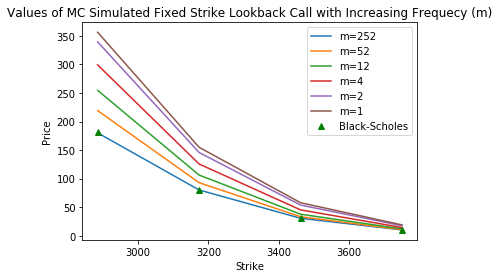

In [20]:
plt.plot(K,k1, '', K, resultsBS,'g^')
plt.title('Values of MC Simulated Fixed Strike Lookback Call with Increasing Frequecy (m)')
plt.ylabel('Price')
plt.xlabel('Strike')
plt.legend(['m=252', 'm=52', 'm=12', 'm=4', 'm=2', 'm=1', 'Black-Scholes'])
plt.show()

In [21]:
# set parameters for incrasing n batches and run MC sim
batches = [1000,10000,100000,1000000]
S = 2885
K = [S, S*1.1, S*1.2, S*1.3]
r = .023
q = .0198
sigma = 0.157
T = 1
dt = T/252
y = .0198
results = []
K_0n = []
K_1n = []
K_2n = []
K_3n = []

for n in batches:
    K_0n.append(lookback_MC(n,[12],S,K[0],r,y,sigma,T))
    K_1n.append(lookback_MC(n,[12],S,K[1],r,y,sigma,T))
    K_2n.append(lookback_MC(n,[12],S,K[2],r,y,sigma,T))
    K_3n.append(lookback_MC(n,[12],S,K[3],r,y,sigma,T))


In [22]:
# create dataframe to display results for various n and k
K0n = pd.DataFrame(K_0n)
K1n = pd.DataFrame(K_1n)
K2n = pd.DataFrame(K_2n)
K3n = pd.DataFrame(K_3n)
K0n.columns = ['MC Price','Std Error']
K0n.index = ['n=1000','n=10000','n=100000','n=1000000']
K1n.columns = ['MC Price','Std Error']
K1n.index = ['n=1000','n=10000','n=100000','n=1000000']
K2n.columns = ['MC Price','Std Error']
K2n.index = ['n=1000','n=10000','n=100000','n=1000000']
K3n.columns = ['MC Price','Std Error']
K3n.index = ['n=1000','n=10000','n=100000','n=1000000']

In [23]:
# create list for plotting
kn = list([K_0n[0][0],K_0n[1][0],K_0n[2][0],K_0n[3][0]])
kn1 = list([K_1n[0][0],K_1n[1][0],K_1n[2][0],K_1n[3][0]])
kn2 = list([K_2n[0][0],K_2n[1][0],K_2n[2][0],K_2n[3][0]])
kn3 = list([K_3n[0][0],K_3n[1][0],K_3n[2][0],K_3n[3][0]])


In [24]:
print('MC Simulation for Fixed Strike Lookback Call (K=S):\n\n',K0n)


MC Simulation for Fixed Strike Lookback Call (K=S):

                        MC Price              Std Error
n=1000      [298.8985142289044]    [9.537275710132835]
n=10000     [302.6589368545867]   [3.0347923253015625]
n=100000     [299.890876157534]   [0.9548922788737594]
n=1000000  [299.52937175836473]  [0.30068818785194495]


In [25]:
print('MC Simulation for Fixed Strike Lookback Call (K=1.1S):\n\n',K1n)

MC Simulation for Fixed Strike Lookback Call (K=1.1S):

                        MC Price              Std Error
n=1000      [140.9896231220353]    [7.637320229798307]
n=10000    [127.88981852442252]   [2.2957206704235262]
n=100000   [124.74382556076151]   [0.7122286812331297]
n=1000000  [124.93153390590759]  [0.22516609104354152]


In [26]:
print('MC Simulation for Fixed Strike Lookback Call (K=1.2S):\n\n',K2n)

MC Simulation for Fixed Strike Lookback Call (K=1.2S):

                        MC Price             Std Error
n=1000      [46.20761352095207]     [4.4379060828925]
n=10000       [43.044951401793]  [1.3460926167226601]
n=100000    [45.32922640267551]  [0.4466312567563223]
n=1000000  [45.210221463696264]  [0.1409908332320315]


In [27]:
print('MC Simulation for Fixed Strike Lookback Call (K=1.3S):\n\n',K3n)

MC Simulation for Fixed Strike Lookback Call (K=1.3S):

                        MC Price              Std Error
n=1000     [10.186471066087753]   [1.8156130907873806]
n=10000    [14.208892261053782]   [0.7942734774383101]
n=100000   [14.187005239617132]  [0.24732146330267696]
n=1000000  [14.465882304572688]  [0.07932087714146721]


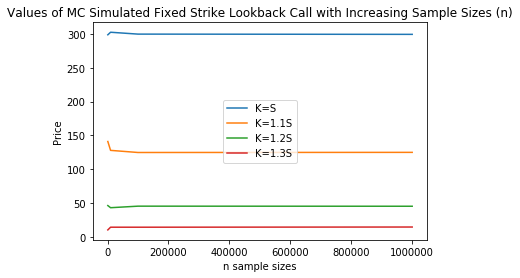

In [28]:
plt.plot(batches,kn, batches, kn1, batches, kn2, batches, kn3)
plt.title('Values of MC Simulated Fixed Strike Lookback Call with Increasing Sample Sizes (n)')
plt.ylabel('Price')
plt.xlabel('n sample sizes')
plt.legend(['K=S', 'K=1.1S', 'K=1.2S', 'K=1.3S'],loc=10)
plt.show()

In [36]:
def fdm_delta_centered(epsilon, S0_arr, pricing_func):
    delta_arr = [] # = np.zeros_like(S0_arr)
    for i in range(len(S0_arr)):
        opt_plus = pricing_func(S0_arr[i]*(1+epsilon))
        opt_minus = pricing_func(S0_arr[i]*(1-epsilon))
        delta_arr.append((opt_plus - opt_minus) / (2*epsilon*S0_arr[i]))
    return delta_arr

def fdm_rhoY(epsilon, S0_arr, pricing_func):
    rhoY_arr = np.zeros_like(S0_arr)
    for i in range(len(S0_arr)):
        opt = pricing_func(S0_arr[i])
        opt_plus = pricing_func(S0_arr[i]*(1+epsilon))
        opt_minus = pricing_func(S0_arr[i]*(1-epsilon))
        rhoY_arr[i] = (opt_plus - opt_minus) / (2*epsilon*S0_arr_rhoY[i])
    return gamma_arr

In [37]:
def plot_sensitivities(epsilon, S0_arr, pricing_func, true_delta, true_gamma):
    
    d_cent = fdm_delta_centered(epsilon, S0_arr, pricing_func)
    plt.subplot(211)
    plt.plot(S0_arr,d_plus, S0_arr,d_minus,S0_arr,d_cent, S0_arr,true_delta)
    
    plt.subplot(212)    
    g = fdm_rhoY(epsilon, S0_arr, pricing_func)
    plt.plot(S0_arr, g, S0_arr,true_gamma)
    plt.show()
    return

In [38]:
# Define parameters and run simulations for each strike
n = 100000
S = 2885
K = [S, S*1.1, S*1.2, S*1.3]
r = .023
q = .0198
sigma = 0.157
T = 1
dt = T/252
results_a = []
resultsCF = []
resultsBS = []

for k in K:
    results_a.append(lookback_MC(n,[1,2,4,12,52,252],S,k,r,y,sigma,T,antithetic='yes'))
    resultsCF.append(lookback_Analytic(S,k,r,q,sigma,T,'fixed strike call'))
    resultsBS.append(BS(S,k,r,q,sigma,T)[0])

In [39]:
# pull values
K_0a = lookback_MC(n,[1,2,4,12,52,252],S,K[0],r,y,sigma,T,antithetic='yes')
K_1a = lookback_MC(n,[1,2,4,12,52,252],S,K[1],r,y,sigma,T,antithetic='yes')
K_2a = lookback_MC(n,[1,2,4,12,52,252],S,K[2],r,y,sigma,T,antithetic='yes')
K_3a = lookback_MC(n,[1,2,4,12,52,252],S,K[3],r,y,sigma,T,antithetic='yes')

In [40]:
# create a list for charting
k1 = list([K_0[0],K_1[0],K_2[0],K_3[0]])
k1se = list([K_0[1],K_1[1],K_2[1],K_3[1]])
k1A = list([K_0a[0],K_1a[0],K_2a[0],K_3a[0]])
k1seA = list([K_0a[1],K_1a[1],K_2a[1],K_3a[1]])
k1seA

[array([0.70271309, 0.6488465 , 0.61511456, 0.59551408, 0.59138667,
        0.59209055]),
 array([0.56734759, 0.57029642, 0.58250501, 0.60051527, 0.61712165,
        0.62343036]),
 array([0.37255415, 0.37943859, 0.39741243, 0.42892694, 0.46096026,
        0.4759036 ]),
 array([0.22451348, 0.22713424, 0.23744805, 0.25718378, 0.28238613,
        0.29451337])]

In [41]:
# Display Results
dfa = pd.DataFrame({'MC Price:':K_0a[0], 'Std Error':K_0a[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=S):\n\n',dfa)
print('\nBS Value for Vanilla Euro Call:',resultsBS[0])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[0])

MC Simulation for Fixed Strike Lookback Call (K=S):

               MC Price:  Std Error
maturity     180.000189   0.702713
semi-annual  219.142395   0.648846
quarterly    254.813928   0.615115
monthly      299.588518   0.595514
weekly       339.715101   0.591387
daily        356.713737   0.592091

BS Value for Vanilla Euro Call: 181.24666946316665

Closed-Form Value for Fixed Strike Lookback Call: 375.96895853236117


In [42]:
# Display Results
dfa = pd.DataFrame({'MC Price:':K_1a[0], 'Std Error':K_1a[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=1.1S):\n\n',dfa)
print('\nBS Value for Vanilla Euro Call:',resultsBS[1])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[1])

MC Simulation for Fixed Strike Lookback Call (K=1.1S):

               MC Price:  Std Error
maturity      79.606542   0.567348
semi-annual   92.415583   0.570296
quarterly    105.843290   0.582505
monthly      125.280282   0.600515
weekly       145.536037   0.617122
daily        154.685365   0.623430

BS Value for Vanilla Euro Call: 80.01123537579667

Closed-Form Value for Fixed Strike Lookback Call: 170.78494203193188


In [43]:
# Display Results
dfa = pd.DataFrame({'MC Price:':K_2a[0], 'Std Error':K_2a[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=1.2S):\n\n',dfa)
print('\nBS Value for Vanilla Euro Call:',resultsBS[2])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[2])

MC Simulation for Fixed Strike Lookback Call (K=1.2S):

              MC Price:  Std Error
maturity     30.654755   0.372554
semi-annual  33.569684   0.379439
quarterly    38.055749   0.397412
monthly      45.708724   0.428927
weekly       54.179655   0.460960
daily        58.287503   0.475904

BS Value for Vanilla Euro Call: 30.656053720348666

Closed-Form Value for Fixed Strike Lookback Call: 67.23070314271794


In [44]:
# Display Results
dfa = pd.DataFrame({'MC Price:':K_3a[0], 'Std Error':K_3a[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=1.3S):\n\n',dfa)
print('\nBS Value for Vanilla Euro Call:',resultsBS[3])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[3])

MC Simulation for Fixed Strike Lookback Call (K=1.3S):

              MC Price:  Std Error
maturity     10.816515   0.224513
semi-annual  11.301071   0.227134
quarterly    12.641592   0.237448
monthly      15.149761   0.257184
weekly       18.332316   0.282386
daily        19.924577   0.294513

BS Value for Vanilla Euro Call: 10.390011362679672

Closed-Form Value for Fixed Strike Lookback Call: 23.37001367688092


In [37]:
# Monte Carlo Simulator
def MC(batches,St,K,r,q,sigma,T,flavor='Call',alpha=0,style='euro',seed=2,t=0):
    dt = T-t
    mu = (r - q - sigma*sigma*0.5)*dt
    
    d1 = ((np.log(St/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) + 0.5*sigma*np.sqrt(dt)
    d2 = ((np.log(St/K) + (r - q)*(dt)) / sigma*np.sqrt(dt)) - 0.5*sigma*np.sqrt(dt)
    #np.random.seed(seed)
    price = []
    stdev = []
    
    for n in batches:
        draws = np.random.normal(size=n)
        stoch = sigma*np.sqrt(dt)*draws
        ST = St*np.exp(mu + stoch)
        ST_ = St*np.exp(mu - stoch)

        
        if flavor == 'Put':
            payoff = np.maximum((K - ST),0)
        elif flavor == 'Call':
            payoff = np.maximum((ST - K),0)
        elif flavor == 'Call Antithetic':
            payoff = np.mean([np.maximum((ST - K),0),np.maximum((ST_ - K),0)],axis=0)
        elif flavor == 'AC':
            payoff = np.maximum((K - K*K/ST),0)
        elif flavor == 'AC Antithetic':
            payoff = np.mean([np.maximum((K - K*K/ST),0),np.maximum((K - K*K/ST_),0)],axis=0)
        elif flavor == 'Control Variate':
            payoff = (K/ST - alpha)* np.maximum((ST - K),0)
        elif flavor == 'Control Variate2':
            payoff = (K/ST - alpha)* np.maximum((ST - K),0) + St*np.exp(-q*dt)*norm.cdf(d1) - K*np.exp(-r*dt)*norm.cdf(d2)
        elif flavor == 'Power Call':
            payoff = np.maximum((ST*ST - K),0)
        else:
            payoff = ST
       
        PVs = np.exp(-r*dt)*payoff 
        price.append(np.mean(PVs))
        stdev.append(np.std(PVs)/np.sqrt(n))
        #print(ST)
    return price, stdev

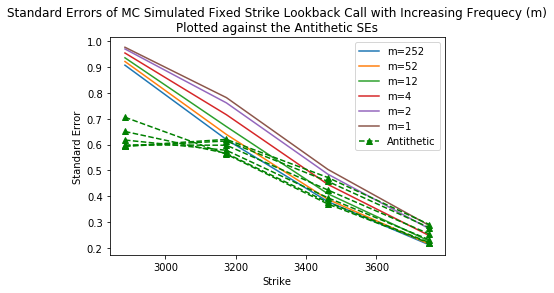

In [38]:
plt.plot(K,k1se, '', K, k1seA,'g^--')
plt.title('Standard Errors of MC Simulated Fixed Strike Lookback Call with Increasing Frequecy (m)\nPlotted against the Antithetic SEs')
plt.ylabel('Standard Error')
plt.xlabel('Strike')
plt.legend(['m=252', 'm=52', 'm=12', 'm=4', 'm=2', 'm=1', 'Antithetic'])
plt.show()

In [101]:
# Lookback Option Monte Carlo Function
def lookback_MC_CV_european(batches, freqs, S,K,r,q,sigma,T,CV_val,flavor='c',style='float',display='no',t=0):
    '''This function generate batches of n normally distributed random variables, which are used to generate 
    a geometric brownian motion along m sample paths.  Then we calculate the maximum values, for each batch, along
    each m paths for the specified frequency of m.  We end up with a row vector of n maximums, which are then
    used to calculate the payoff.  We take the mean of each of these, and discount to the present value.'''
    num_steps = 252
    dt = T/num_steps
    
    ST = np.zeros((num_steps+1,batches))
    
    
    Smax = []
    Smin = []
    ST[0,:] = S
    
    
    
    payout = np.zeros(num_steps)
    payoutLookback = []
    lookbackMean = []
    lookbackVariance = []
    PV = []
    
    for i in range(0,num_steps):   
        mu = (r - q - sigma*sigma*0.5)*dt
        draws = np.random.normal(size=batches)
        stoch = sigma*np.sqrt(dt)*draws
    
        ST[i+1,:] = ST[i,:]*np.exp(mu + stoch)

    
    for m in freqs:
        Smax.append(np.max(ST[int(num_steps/m)-1:num_steps:int(num_steps/m)],axis=0))


    for i in range(0,len(freqs)):
        payoutLookback = np.exp(-r*T)*np.maximum((Smax[i] - K),0)
        payout_euro = np.exp(-r*T)*(np.maximum(ST[-1,:]-K,0))
        diff = payoutLookback - payout_euro
        CV_adj = np.mean(diff)
        lookbackVariance.append(np.std(diff))
        lookbackMean.append((CV_val + CV_adj))
   
    return lookbackMean,lookbackVariance/np.sqrt(batches)

# Lookback Option Monte Carlo Function
def lookback_MC_CV_bridge(batches, freqs, S,K,r,q,sigma,T,CV_val,flavor='c',style='float',display='no',t=0):
    '''This function generate batches of n normally distributed random variables, which are used to generate 
    a geometric brownian motion along m sample paths.  Then we calculate the maximum values, for each batch, along
    each m paths for the specified frequency of m.  We end up with a row vector of n maximums, which are then
    used to calculate the payoff.  We take the mean of each of these, and discount to the present value.'''
    
    
    num_steps = 252
    dt = T/num_steps
    
    ST = np.zeros((num_steps,batches))
    
    
    Smax = []
    Smin = []
    ST[0,:] = S
    
    
    
    payout = np.zeros(num_steps)
    payoutLookback = []
    lookbackMean = []
    lookbackVariance = []
    PV = []
    
    for i in range(1,num_steps):   
        mu = (r - q - sigma*sigma*0.5)*dt
        draws = np.random.normal(size=batches)
        stoch = sigma*np.sqrt(dt)*draws
    
        ST[i,:] = ST[i-1,:]*np.exp(mu + stoch)

    
    for m in freqs:
        Smax.append(np.max(ST[int(num_steps/m)-1:num_steps:int(num_steps/m)],axis=0))


    for i in range(0,len(freqs)):
        m= freqs[i]
        if freqs[i]==1:
            x_t = (ST[-1,:] - ST[0,:])/ST[0,:]  # Normalize for starting at 0
            u = np.random.uniform(size=(batches))
            b_max = (((x_t + np.sqrt(x_t**2-2*sigma**2 * T*np.log(u)))/2)*ST[0,:]) + ST[0,:] # Reverse normalization from above
        
        else:
            temp_ref = list(range(0,252))
            temp_index = temp_ref[int(num_steps/m)-1:num_steps:int(num_steps/m)]
            b_max = np.zeros((len(temp_index),batches))
            for j in range(len(temp_index)):
                x_t = (ST[temp_index[j],:]-ST[temp_index[j-1],:]) / (ST[temp_index[j-1],:])
                u = np.random.uniform(size=(batches))
                b_max[j,:] = (((x_t + np.sqrt(x_t**2-2*sigma**2 * (T/m)*np.log(u)))/2)*ST[temp_index[j-1],:]) + ST[temp_index[j-1],:] # Reverse normalization from above
            
            b_max = np.max(b_max,axis=0)
        payoutLookback = np.exp(-r*T)*np.maximum((Smax[i] - K),0)
        payout_cts = np.exp(-r*T)*(np.maximum(b_max-K,0))
        diff = payout_cts - payoutLookback
        CV_adj = np.mean(diff)
        lookbackVariance.append(np.std(diff))
        lookbackMean.append((CV_val - CV_adj))
   
    return lookbackMean,lookbackVariance/np.sqrt(batches)


In [102]:
cv_val = BS(2885,2885,r,q,sigma,T,flavor='c',style='euro',display='no',t=0)[0]
K_0 = lookback_MC_CV_european(n,[1,2,4,12,52,6048],S,K[0],r,y,sigma,T,cv_val)

In [103]:
# Display Results
df = pd.DataFrame({'MC Price:':K_0[0], 'Std Error':K_0[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=S):\n\n',df)
print('\nBS Value for Vanilla Euro Call:',resultsBS[0])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[0])

MC Simulation for Fixed Strike Lookback Call (K=S):

               MC Price:  Std Error
maturity     180.893069   0.068996
semi-annual  220.271018   0.306794
quarterly    256.170791   0.386590
monthly      300.290472   0.441894
weekly       340.353236   0.468870
daily        358.109729   0.472274

BS Value for Vanilla Euro Call: 181.24666946316665

Closed-Form Value for Fixed Strike Lookback Call: 375.96895853236117


In [104]:
u = np.random.uniform()
x_t = -1
b_max = (x_t + np.sqrt(x_t**2-2*sigma**2 * T*np.log(u)))/2
print(b)

0.013553236671628


In [105]:
cv_val = lookback_Analytic(2885,2885,r,q,sigma,T,flavor = 'fixed strike call',t=0)

In [106]:
# Display Results
K_0 = lookback_MC_CV_bridge(n,[1,2,4,12,52,252],2885,2885,r,y,sigma,T,375.96)
df = pd.DataFrame({'MC Price:':K_0[0], 'Std Error':K_0[1]},index = ['maturity','semi-annual','quarterly','monthly','weekly','daily'])
print('MC Simulation for Fixed Strike Lookback Call (K=S):\n\n',df)
print('\nBS Value for Vanilla Euro Call:',resultsBS[0])
print('\nClosed-Form Value for Fixed Strike Lookback Call:',resultsCF[0])

MC Simulation for Fixed Strike Lookback Call (K=S):

               MC Price:  Std Error
maturity     198.893458   0.420932
semi-annual  247.847502   0.364587
quarterly    276.555549   0.252173
monthly      309.594235   0.146812
weekly       337.701385   0.069846
daily        358.141197   0.030167

BS Value for Vanilla Euro Call: 181.24666946316665

Closed-Form Value for Fixed Strike Lookback Call: 375.96895853236117


> We can see the variance is reduced significantly using both methods of control variates